<a href="https://colab.research.google.com/github/LoniQin/lifelong-ml/blob/main/Building_RAG_application_with_HayStack%2C_GEMINI_and_Cohere.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building RAG application with HayStack, GEMINI and Cohere

This notebook demonstrates how to build a RAG application using Haystack, Gemini, and Cohere.
It covers the following steps:

1. **Setting up the environment:** Installing necessary libraries and setting up API keys.
2. **Indexing Documents:** Shows how to index documents using Cohere for embedding and an InMemoryDocumentStore.
3. **Building a RAG Pipeline:** Constructs a RAG pipeline with Cohere for embedding, an InMemoryEmbeddingRetriever, a PromptBuilder, and a Gemini Generator.
4. **Customizing the RAG Pipeline:**  Illustrates how to customize the prompt and generate responses in different languages.

## Setting up the environment

This section installs the required libraries for the RAG application using pip.
It also sets up the API keys for Gemini and Cohere by retrieving them from user data.

In [ ]:
!pip install -q google-ai-haystack cohere-haystack trafilatura

In [2]:
from haystack import Pipeline
from haystack.utils.auth import Secret
from haystack.components.builders import PromptBuilder
from haystack.components.converters import HTMLToDocument
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator
from haystack_integrations.components.embedders.cohere import CohereDocumentEmbedder, CohereTextEmbedder
from haystack.dataclasses import ChatMessage
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiChatGenerator
from google.colab import userdata
import os
GEMINI_API_KEY = userdata.get('GEMINI_API_KEY')
CO_API_KEY = userdata.get('CO_API_KEY')
os.environ['CO_API_KEY'] = CO_API_KEY
os.environ["GOOGLE_API_KEY"] = GEMINI_API_KEY

/usr/local/lib/python3.10/dist-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


## Indexing Documents

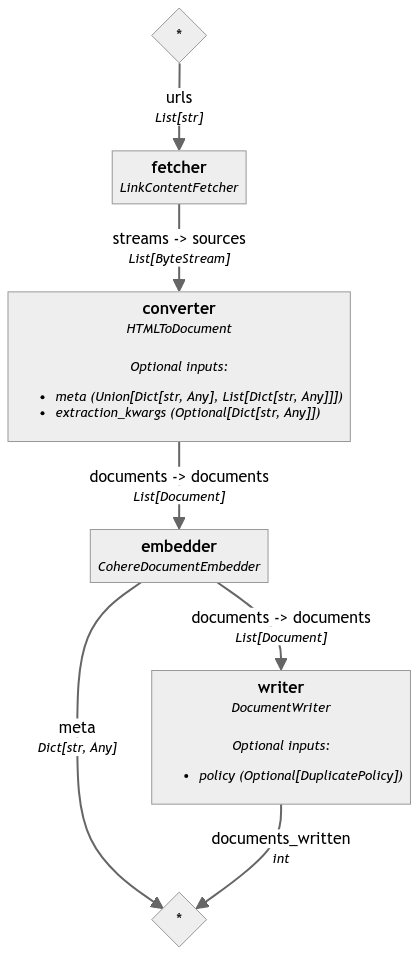

In [19]:
document_store = InMemoryDocumentStore()
fetcher = LinkContentFetcher()
converter = HTMLToDocument()
embedder = CohereDocumentEmbedder(model="embed-english-v3.0")
writer = DocumentWriter(document_store=document_store)

indexing = Pipeline()
indexing.add_component("fetcher", fetcher)
indexing.add_component("converter", converter)
indexing.add_component("embedder", embedder)
indexing.add_component("writer", writer)

indexing.connect("fetcher.streams", "converter.sources")
indexing.connect("converter", "embedder")
indexing.connect("embedder", "writer")
indexing.show()

In [20]:
indexing.run(
    {
        "fetcher": {
            "urls": [
                "https://haystack.deepset.ai/integrations/cohere",
                "https://haystack.deepset.ai/integrations/anthropic",
                "https://haystack.deepset.ai/integrations/jina",
                "https://haystack.deepset.ai/integrations/nvidia",
            ]
        }
    }
)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  3.87it/s]


{'embedder': {'meta': ApiMeta(api_version=ApiMetaApiVersion(version='1', is_deprecated=None, is_experimental=None), billed_units=ApiMetaBilledUnits(input_tokens=2032.0, output_tokens=None, search_units=None, classifications=None), tokens=None, warnings=[])},
 'writer': {'documents_written': 4}}

In [21]:
from haystack_integrations.components.generators.google_ai import GoogleAIGeminiGenerator

### 3. Build the RAG Pipeline

This section constructs a Retrieval Augmented Generation (RAG) pipeline using Haystack components.

It initializes a `PromptBuilder` with a prompt template that incorporates context from retrieved documents.
A `CohereTextEmbedder` is used for embedding the query, and an `InMemoryEmbeddingRetriever` searches the document store.
Finally, a `GoogleAIGeminiGenerator` generates the response based on the prompt and retrieved context.

Augment the prompt with the contents of these documents using the [`PromptBuilder`](https://docs.haystack.deepset.ai/docs/promptbuilder?utm_campaign=developer-relations&utm_source=dlai). This component uses Jinja templating [[+]](https://jinja.palletsprojects.com/en/3.1.x/)

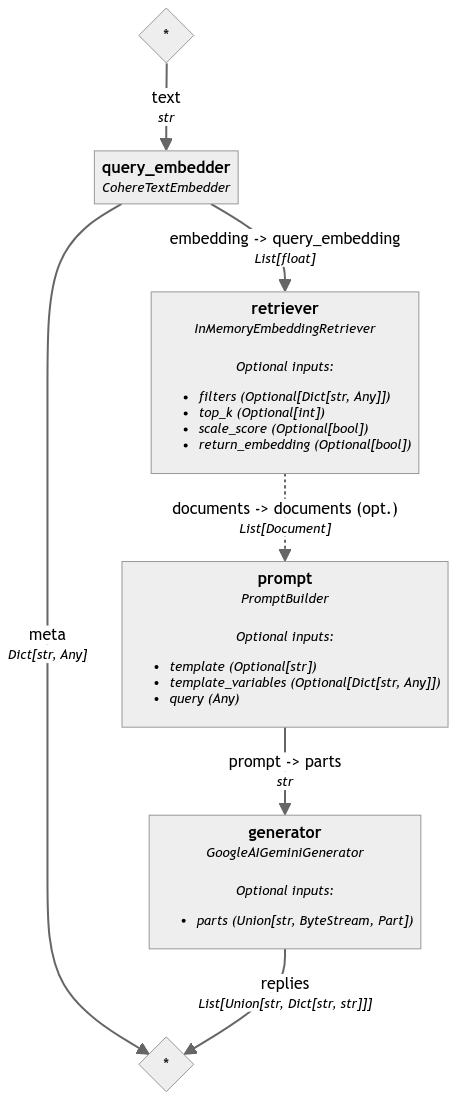

In [13]:
prompt = """
Answer the question based on the provided context.
Context:
{% for doc in documents %}
   {{ doc.content }}
{% endfor %}
Question: {{ query }}
"""
query_embedder = CohereTextEmbedder(model="embed-english-v3.0")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = GoogleAIGeminiGenerator(model="gemini-1.5-flash")

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")
rag.show()

In [22]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question},
    }
)

print(result["generator"]["replies"][0])

You can use Cohere models with Haystack for embedding, generating, and ranking.  You can use Cohere Models in your Haystack 2.0 pipelines with the Generators and Embedders. You can also use Cohere models in your Haystack 1.x pipelines with the EmbeddingRetriever, PromptNode, and CohereRanker.  [https://haystack.deepset.ai/integrations/cohere]


### 4. Customize The Behaviour and input in Different Language.

This section demonstrates how to customize the RAG pipeline for multilingual support.

The prompt template is modified to instruct the language model to generate responses in a specified language.
The pipeline remains the same, but the input now includes a "language" parameter to control the output language.

In [15]:
prompt = """
You will be provided some context, followed by the URL that this context comes from.
Answer the question based on the context, and reference the URL from which your answer is generated.
Your answer should be in {{ language }}.
Context:
{% for doc in documents %}
   {{ doc.content }}
   URL: {{ doc.meta['url']}}
{% endfor %}
Question: {{ query }}
Answer:
"""

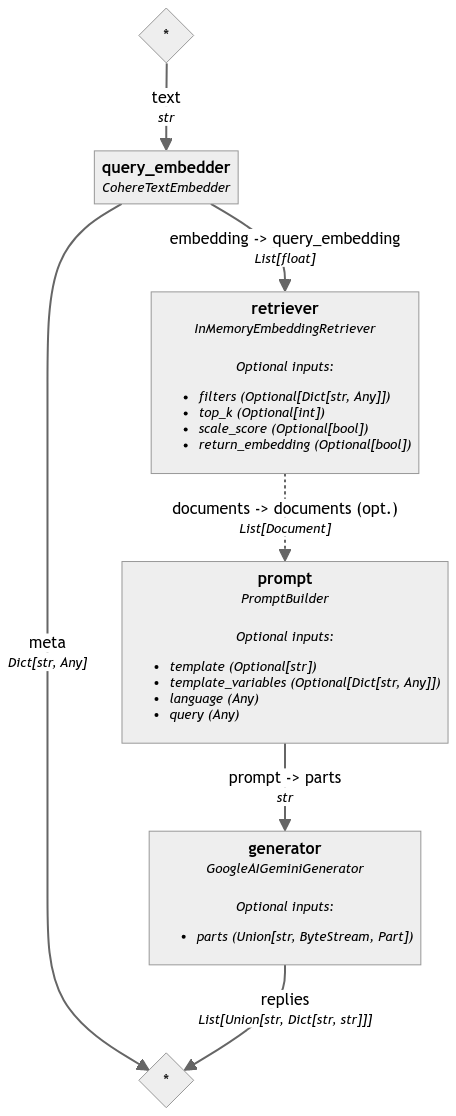

In [16]:
query_embedder = CohereTextEmbedder(model="embed-english-v3.0")
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = PromptBuilder(template=prompt)
generator = GoogleAIGeminiGenerator(model="gemini-1.5-flash")

rag = Pipeline()
rag.add_component("query_embedder", query_embedder)
rag.add_component("retriever", retriever)
rag.add_component("prompt", prompt_builder)
rag.add_component("generator", generator)

rag.connect("query_embedder.embedding", "retriever.query_embedding")
rag.connect("retriever.documents", "prompt.documents")
rag.connect("prompt", "generator")
rag.show()

In [23]:
question = "How can I use Cohere with Haystack?"

result = rag.run(
    {
        "query_embedder": {"text": question},
        "retriever": {"top_k": 1},
        "prompt": {"query": question, "language": "French"},
    }
)

print(result["generator"]["replies"][0])

Vous pouvez utiliser les modèles Cohere dans vos pipelines Haystack 2.0 avec les générateurs et les embedders. Vous pouvez utiliser les modèles Cohere de différentes manières : pour les modèles d'embedding, les modèles génératifs (LLMs) et les modèles de classement.  [https://haystack.deepset.ai/integrations/cohere](https://haystack.deepset.ai/integrations/cohere)

